## submitted by: Inbar Dabush 207703745, Maayan Antar 317705382 ##

# Part 2: Define the problem

Classification problem: prediction of chronic kidney disease based on albumin values

In [6]:
import pandas as pd
import sklearn.neighbors as nb
import seaborn as sns
import scipy.stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
import sklearn.datasets, sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score, fowlkes_mallows_score
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE 
from sklearn.metrics import roc_auc_score
sns.set(style='white',context='talk',palette='Set1')

# part 3 : EDA

In [7]:
#(1)
data = pd.read_csv("data_kidney_disease.csv")
data.head()
 #פתחנו את הקובץ ופתחנו את 5 השורות הראשונות כדי לקבל מושג על אופי הדאטה

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [8]:
#(2)
data = data.dropna(axis=0)
data = data.drop_duplicates().reset_index(drop=True)
data.head()

#קודם כל בדקנו אם יש לנו ערכים חסרים בדאטה, לאחר מכן הורדנו שורות עם ערכים חסרים ושורות עם ערכים כפולים. 
#אחרי זה פירקנו משתנים קטגוריאליים לבינאריים (כשהדפסנו את ההד בעצם יכולנו לראות איך הדאטה נראה ואיזה סוג מידע יש תחת כל משתנה)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
2,11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
3,14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
4,20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd


## summerized data

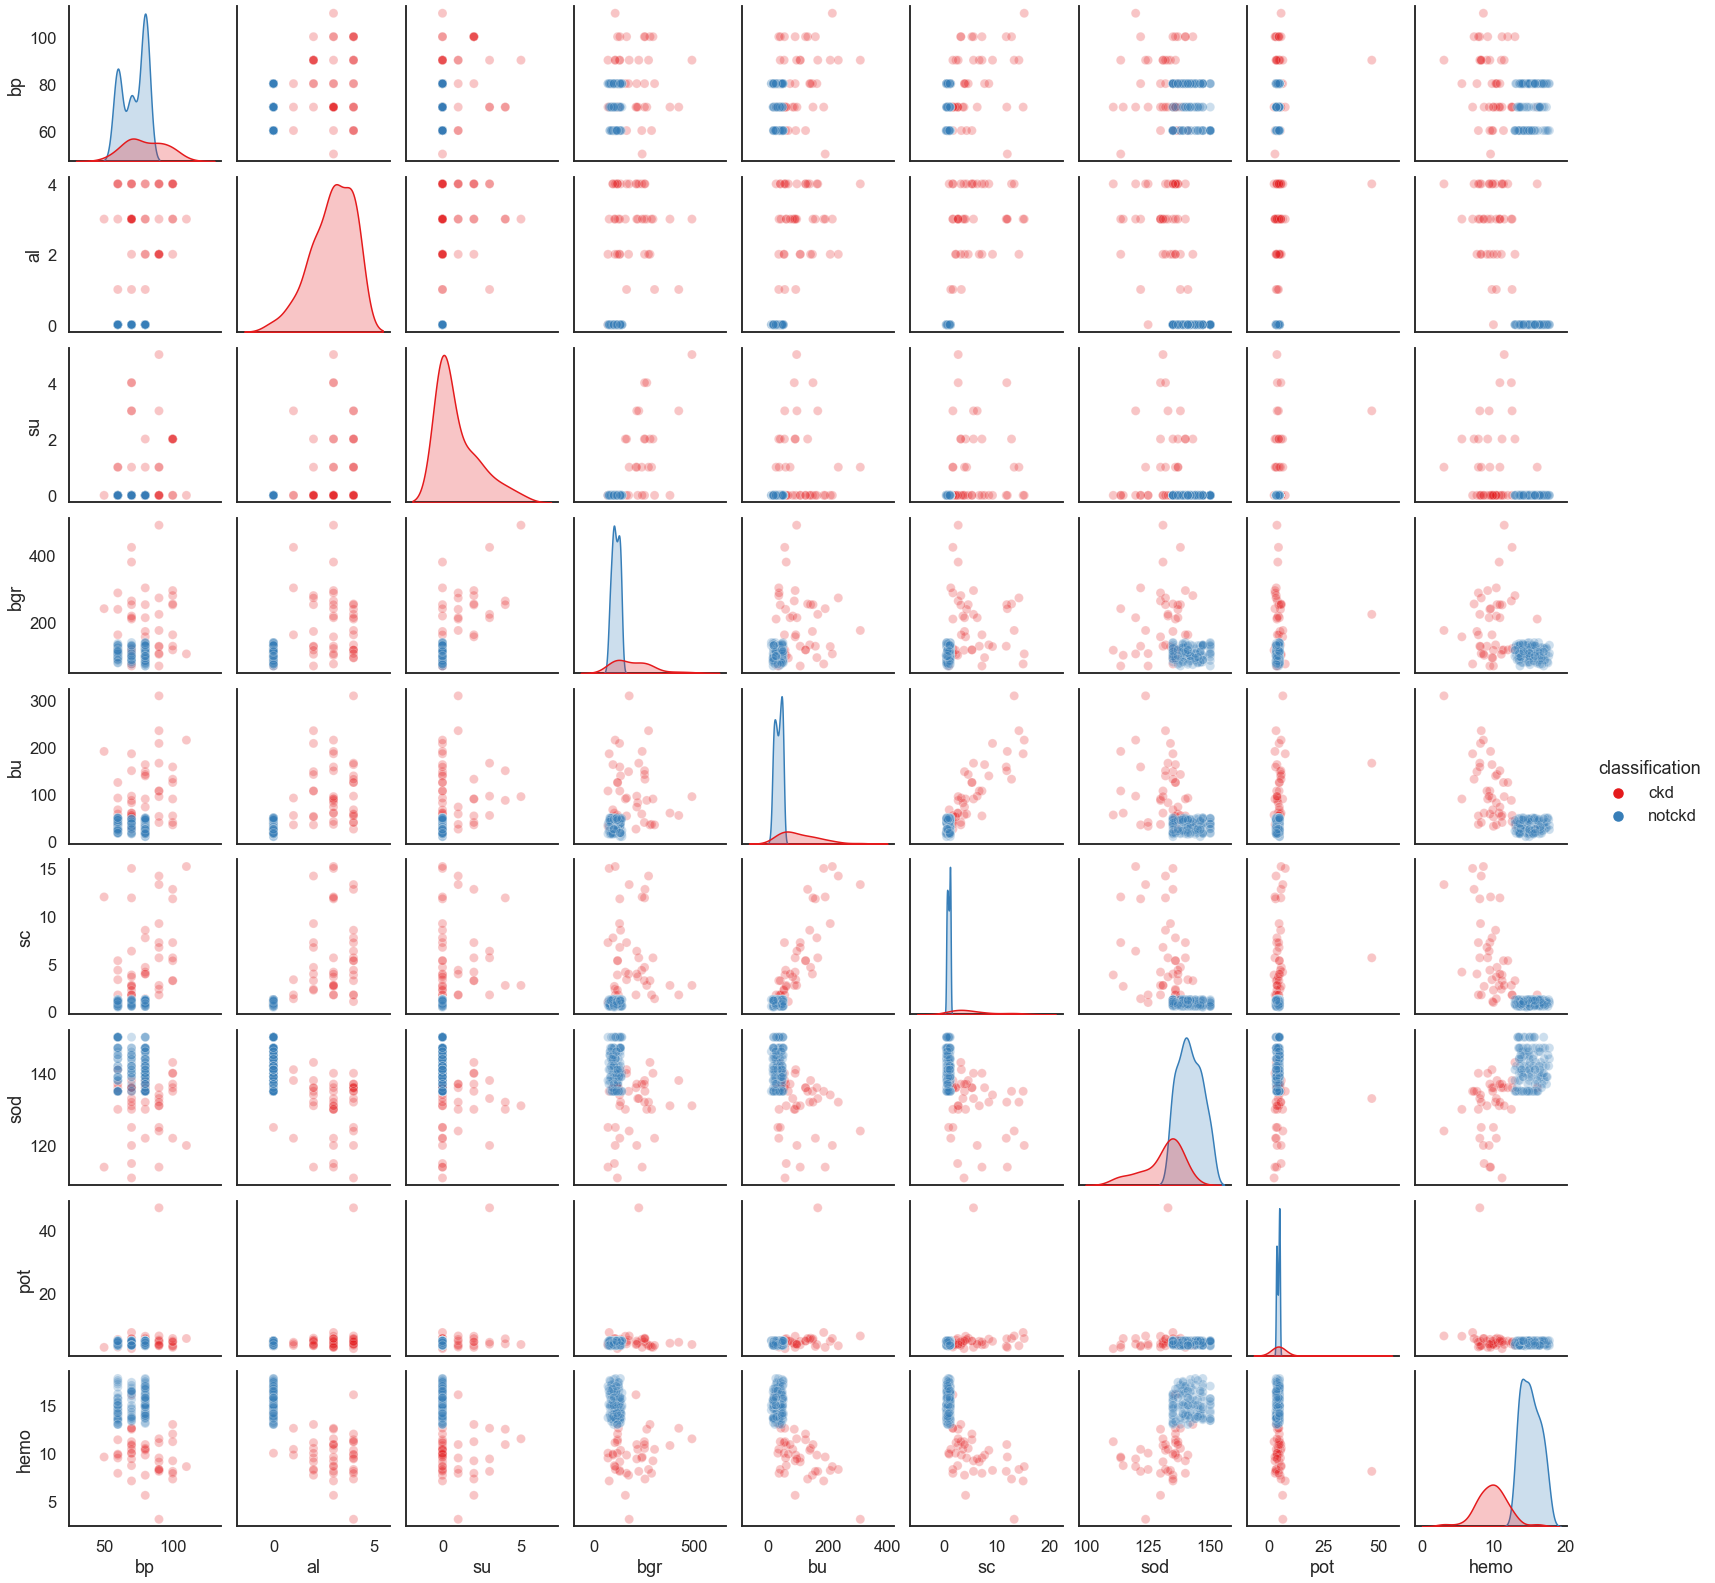

In [9]:
#(3)
sns.pairplot(data.drop(columns=['id','age', 'appet','sg','pcc']),hue='classification', plot_kws=dict(alpha=0.25));

In [10]:
#(4)
data.dtypes
#בדקנו אילו סוגי נתונים יש בכל עמודה בדאטה כדי שנדע מהם המשתנים הקטגוריאליים

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

## preprocessing steps

In [11]:
#(5)
data = pd.get_dummies(data= data, prefix=['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane','classification'],
                       columns=['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane','classification'], drop_first=True )
data.head()
#פירקנו את המשתנים הקטגוריאליים למשתנים בוליאנים כדי שנוכל לעבוד עם הדאטה

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes,classification_notckd
0,3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,...,0,1,0,1,0,0,1,1,1,0
1,9,53.0,90.0,1.020,2.0,0.0,70.0,107.0,7.2,114.0,...,0,1,0,1,1,0,1,0,1,0
2,11,63.0,70.0,1.010,3.0,0.0,380.0,60.0,2.7,131.0,...,0,1,0,1,1,0,1,1,0,0
3,14,68.0,80.0,1.010,3.0,2.0,157.0,90.0,4.1,130.0,...,0,1,1,1,1,1,1,1,0,0
4,20,61.0,80.0,1.015,2.0,0.0,173.0,148.0,3.9,135.0,...,0,0,0,1,1,1,1,1,1,0


## correlation test:

                            age        bp        sg        al        su  \
age                    1.000000  0.079712 -0.277303  0.253380  0.207711   
bp                     0.079712  1.000000 -0.198897  0.322507  0.243828   
sg                    -0.277303 -0.198897  1.000000 -0.712331 -0.448477   
al                     0.253380  0.322507 -0.712331  1.000000  0.521448   
su                     0.207711  0.243828 -0.448477  0.521448  1.000000   
bgr                    0.301915  0.190113 -0.544781  0.518123  0.730050   
bu                     0.190636  0.316287 -0.545319  0.661940  0.312259   
sc                     0.189721  0.386551 -0.563122  0.702889  0.347196   
sod                   -0.102933 -0.224710  0.539285 -0.599334 -0.242491   
pot                    0.006866  0.127801 -0.075057  0.209492  0.271954   
hemo                  -0.245645 -0.282365  0.682086 -0.784745 -0.385511   
rbc_normal            -0.147971 -0.316670  0.500494 -0.489941 -0.256568   
pc_normal             -0.

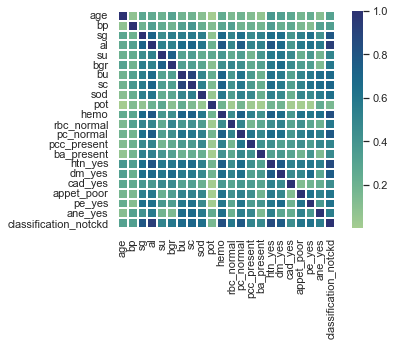

In [12]:
#(6)
cormat = data[data.drop(columns= ['id']).columns].corr()
sns.set_theme(font_scale=1)
print(cormat)
sns.heatmap(abs(cormat), yticklabels=True, square = True, linewidths=0.2 ,cmap="crest"); 
#כיוון שאנחנו מנסים לחזות הופעת מחלה, בדקנו אילו משתנים נמצאים בקורלציה הגבוהה ביותר עם המשתנה הזה
#לאחר שפירקנו בסעיפים הקודמים את המשתנים, הטבלה שקיבלנו רלוונטית עבור מי שאין לו מחלה, ולכן למי שאין מחלה יש אלבומין גבוהה (קורלציה חיובית)
#ומי שיש לו המוגלובין נמוך (קורלציה של

#### ביצענו מבחני פירסון וספירמן עבור המשתנה עם הקורלציה הגבוהה ביותר ועבור המשתנה עם הקורלציה הנמוכה ביותר #####
#מבחני פירסון וספירמן עבור המשתנה עם הקורלציה החיובית הגבוהה ביותר
pearson_r, pearson_pval = scipy.stats.pearsonr(data['classification_notckd'],data['hemo'])
print(f"Pearson(hemo): r = {pearson_r}, p-value = {pearson_pval}")
spearman_r, spearman_pval = scipy.stats.spearmanr(data['classification_notckd'],data['hemo'])
print(f"Spearman(hemo): r = {spearman_r}, p-value = {spearman_pval}")
#מבחני פירסון וספירמן עבור השמתנה עם הקורלציה השלילית ביותר
pearson_r, pearson_pval = scipy.stats.pearsonr(data['classification_notckd'],data['al'])
print(f"Pearson(al): r = {pearson_r}, p-value = {pearson_pval}")
spearman_r, spearman_pval = scipy.stats.spearmanr(data['classification_notckd'],data['al'])
print(f"Spearman(al): r = {spearman_r}, p-value = {spearman_pval}")


## Two sample T-test :


null hypothesis : ckd chances equal among both groups - with/without diabetes mellitus.

Hypothesis : there is a diffrence 


In [13]:
#(7)
ckd_al = data.loc[data.classification_notckd == 0]['hemo'] 
nonckd_al = data.loc[data.classification_notckd == 1]['hemo'] 
scipy.stats.ttest_ind(ckd_al ,nonckd_al)


Ttest_indResult(statistic=-18.863191994768314, pvalue=4.315195029681358e-42)

small p-value --> our hypothesis is true 

because the statistic is negative the average score of hemoglobin among the people having a Chronic Kidney Disease is lower. (not_Chronic_Kidney_Disease hemo > Chronic_Kidney_Disease hemo)



## Anova test :

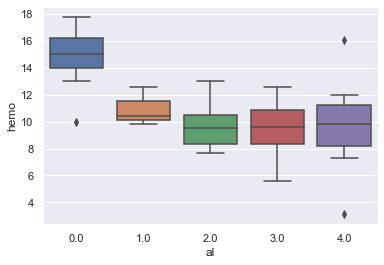

In [14]:
#(8)
sns.boxplot(data=data, x="al", y="hemo");


In [15]:
#(9)
model = ols('hemo ~ (al)', data=data).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
al,1.0,803.167692,803.167692,250.064689,3.173554e-34
Residual,156.0,501.046991,3.211840,NaN,NaN


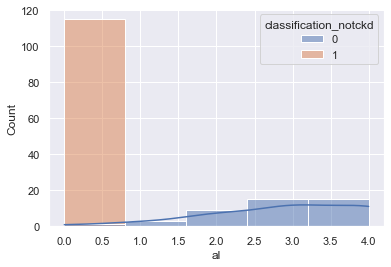

In [16]:
#(10)
sns.histplot(data=data, x='al', hue='classification_notckd', kde = True, bins = 5);

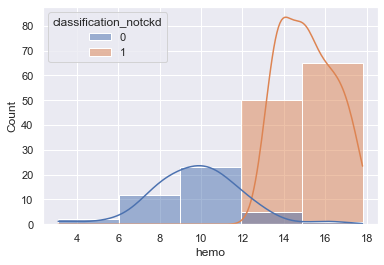

In [17]:
#(11)
sns.histplot(data=data, x='hemo', hue='classification_notckd', kde = True, bins = 5);

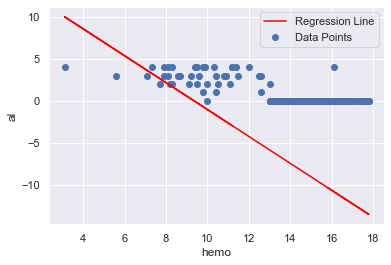

In [18]:
#(12)
#linear regerssion

model_0 = ols(formula="hemo ~ al", data=data).fit()
intercept, slope = model_0.params
predicted_al = intercept + slope * data['hemo'] 

### b

# Create a scatter plot of the data points
plt.scatter(data['hemo'], data['al'], label='Data Points')

# Plot the regression line on top of it
plt.plot(data['hemo'], predicted_al , color='red', label='Regression Line')

# Add labels and a legend
plt.xlabel('hemo')
plt.ylabel('al')
plt.legend();


In [19]:
#(13)
print(model_0.summary())

                            OLS Regression Results                            
Dep. Variable:                   hemo   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     250.1
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           3.17e-34
Time:                        16:37:49   Log-Likelihood:                -315.37
No. Observations:                 158   AIC:                             634.7
Df Residuals:                     156   BIC:                             640.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.9637      0.164     91.332      0.0

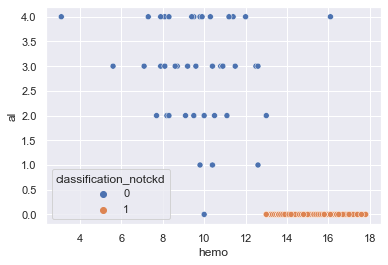

In [48]:
#(14)
sns.scatterplot(x="hemo",
                    y="al",
                    hue="classification_notckd",
                    data=data);

In [21]:
#(15)
model_1 = ols(formula="bu ~ hemo+sc+C(classification_notckd)", data=data).fit()
print(model_1.params)
print("New model R^2:" , model_1.rsquared)

Intercept                        54.435393
C(classification_notckd)[T.1]    -1.851122
hemo                             -1.997336
sc                               12.257163
dtype: float64
New model R^2: 0.8115381498567322


# Part 4: DSA

## Splitting the data into training and testing sets: ## 

In [22]:

X = data.drop(columns = ['id','classification_notckd']) #remove our target variable , the row index and the site variable
y = data['classification_notckd']
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2, random_state = 0)
#תחילה הורדנו את עמודה הלא רלוונטית של והורדנו את עמודת המטרה, פיצלנו את הדאטה לסט בדיקה ולסט אימון


## linear regression ##

In [50]:
lm = LinearRegression()
lm.fit(x_train,y_train)
lm_train_score = lm.score(x_train,y_train)
lm_test_score = lm.score(x_test,y_test)
print(f"Linear model train score = {round(lm_train_score,2)}, Linear model test score = {round(lm_test_score,2)}")


Linear model train score = 0.97, Linear model test score = 0.85
[ 5.98732745e-04  2.70991452e-04  8.72334882e+00 -1.69894481e-01
  3.99882627e-02 -3.24245876e-04  5.74684105e-04 -1.84697043e-02
  4.08240069e-03  8.54147160e-05  8.05264528e-03  3.84477560e-03
 -1.46875341e-05  2.55507509e-02  1.79014530e-01 -1.24188184e-02
 -1.10538506e-02  9.78880228e-02 -2.25314932e-01 -2.46284261e-02
 -1.30285578e-01  1.16485960e-01  1.25164916e-01  1.06648955e-01]


## Regularized linear model:

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

In [25]:
lm_lasso = Lasso()
lm_lasso.fit(x_train_st,y_train)
lm_lasso_train_score = lm_lasso.score(x_train_st,y_train)
lm_lasso_test_score = lm_lasso.score(x_test_st,y_test)
print(f"Lasso train score = {round(lm_lasso_train_score,2)}, Lasso test score = {round(lm_lasso_test_score,2)}")

Lasso train score = 0.0, Lasso test score = -0.0


In [26]:
print(f'Lasso coefficients: {lm_lasso.coef_}')

Lasso coefficients: [-0. -0.  0. -0. -0. -0. -0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0.]


In [27]:
lm_ridge = Ridge()
lm_ridge.fit(x_train_st,y_train)
lm_ridge_train_score = lm_ridge .score(x_train_st,y_train)
lm_ridge_test_score = lm_ridge .score(x_test_st,y_test)
print(f"Ridge train score = {round(lm_ridge_train_score,2)}, Ridge test score = {round(lm_ridge_test_score,2)}")

Ridge train score = 0.97, Ridge test score = 0.86


In [28]:
print(f'Ridge coefficients: {lm_ridge.coef_}')

Ridge coefficients: [ 8.21152911e-03  1.68573590e-03  5.10141009e-02 -2.31673546e-01
  3.16225880e-02 -2.21834059e-02  2.12096476e-02 -4.95620645e-02
  3.03192113e-02 -2.51230176e-04  2.35037863e-02  3.40166080e-02
 -4.72937653e-02  2.46756775e-02  5.73838461e-02 -2.89927360e-05
 -3.39767006e-03  2.33552501e-02 -9.24655396e-02 -7.29964533e-03
 -2.93491219e-02  3.68466448e-02  4.03219773e-02  3.12473674e-02]


In [29]:
cv_scores = cross_val_score(Ridge(), x_train_st, y_train, cv = 5)
print(f"CV scores on each fold: {cv_scores}")
print(f'Mean CV score = {round(np.mean(cv_scores),2)}')

CV scores on each fold: [0.87334458 0.86055846 0.91652344 0.75574571 0.71005748]
Mean CV score = 0.82


## Logistic regression

In [30]:

from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(max_iter=1000)
lg.fit(x_train,y_train)

features = data.drop(columns = ['id','classification_notckd']).columns
intercept = lg.intercept_[0] 
coefficients = lg.coef_[0] 
feature_name = features.insert(0,"intercept")

coeff_table = pd.DataFrame({'coeff': [intercept] + list(coefficients), 'features': feature_name}) 
print(coeff_table) 

       coeff     features
0  -0.000648    intercept
1  -0.048849          age
2  -0.103559           bp
3  -0.000856           sg
4  -0.113113           al
5  -0.006571           su
6  -0.104158          bgr
7  -0.270923           bu
8  -0.077347           sc
9   0.368475          sod
10  0.024087          pot
11  0.071860         hemo
12  0.287609          pcv
13 -0.002555           wc
14  0.011868           rc
15  0.017634   rbc_normal
16  0.015001    pc_normal
17 -0.015881  pcc_present
18 -0.000381   ba_present
19 -0.016361      htn_yes
20 -0.000693       dm_yes
21 -0.000270      cad_yes
22 -0.016037   appet_poor
23 -0.016036       pe_yes
24 -0.015864      ane_yes


In [31]:

from sklearn.metrics import accuracy_score, recall_score, precision_score
y_pred_lg = lg.predict(x_test) #prediction using a threshold of P > 0.5
tn_lg, fp_lg, fn_lg, tp_lg = confusion_matrix(y_test, y_pred_lg).ravel()
accuracy_lg = (y_pred_lg==y_test).mean()
tpr_lg = tp_lg/(tp_lg+fn_lg)
fpr_lg = fp_lg/(fp_lg+tn_lg)
print(f'Accuracy = {round(accuracy_lg,5)}, TPR = {round(tpr_lg,2)}, FPR = {round(fpr_lg,2)} ')

Accuracy = 0.96875, TPR = 1.0, FPR = 0.12 


# Decision tree classifier

In [32]:

classifier_DT = DecisionTreeClassifier() #פונקציה שבונה עץ החלטה
classifier_DT.fit(x_train, y_train)
y_pred_DT = classifier_DT.predict(x_test)

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred_DT))

Accuracy: 0.96875


In [34]:

print(sklearn.tree.export_text(classifier_DT, feature_names= list(features), max_depth=3))

|--- al <= 0.50
|   |--- class: 1
|--- al >  0.50
|   |--- class: 0



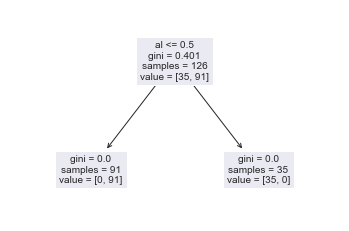

In [35]:

sklearn.tree.plot_tree(classifier_DT, feature_names=list(features), fontsize=10);

In [36]:
print(f'Accuracy={round(accuracy_score(y_test, y_pred_DT),2)}, Precision:{round(precision_score(y_test, y_pred_DT),2)}, Recall:{round(recall_score(y_test,y_pred_DT),2) }')

Accuracy=0.97, Precision:0.96, Recall:1.0


### KNN model

In [37]:

knn = nb.KNeighborsClassifier()
knn.fit(x_train, y_train); 

In [38]:

y_pred_knn = knn.predict(x_test) #פרדיקט מחזיר 0 או 1, זה לא משתנה רציף
print('Accuracy:', round((y_pred_knn == y_test).mean(),3))

Accuracy: 0.875


### Improving the models using hyper-paramenter tuning

In [39]:

classifier_Bag_lg = BaggingClassifier(LogisticRegression(max_iter=1000), 10)
classifier_Bag_lg.fit(x_train, y_train)
y_pred_Bag_lg = classifier_Bag_lg.predict(x_test)
print("Logistic model Accuracy:", accuracy_score(y_test, y_pred_Bag_lg))

Logistic model Accuracy: 0.96875


In [40]:

classifier_Bag_DT = BaggingClassifier(DecisionTreeClassifier(), 10)
classifier_Bag_DT.fit(x_train, y_train)
y_pred_Bag_DT = classifier_Bag_DT.predict(x_test)
print("Deciton tree model Accuracy:", accuracy_score(y_test, y_pred_Bag_DT))

Deciton tree model Accuracy: 0.96875


# Part 5 :Evaluate model performance

### Logistic regrestion

In [41]:

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lg).ravel() #נותן את כל הערכים האלו ישירות
precision_knn = tp/(tp+fp)
recall_knn  = tp/(tp+fn)
F1_score_knn  = (2*precision_knn*recall_knn )/(precision_knn+recall_knn)
print(f"precision = {round(precision_knn ,2)}, recall = {round(recall_knn ,2)}, F1 score = {round(F1_score_knn,2)} ")

precision = 0.96, recall = 1.0, F1 score = 0.98 


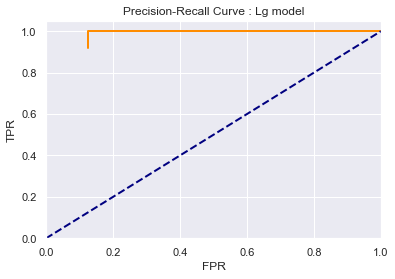

In [42]:
#1.
def get_threshold_tpr_fpr(threshold, test_probs, test_labels):
    y_pred = test_probs > threshold
    tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
    tpr= tp/(tp+fn)
    fpr = fp/(fp+tn)
    return tpr,fpr
#2.
lg_probs = lg.predict_proba(x_test)[:,1] # Probability of obtaining 1  #מחזיר נאמפי אריי שהוא ההסתברות שזה חוזה, ואז ואפשר לקחת עמודה ספציפית
tpr_scores = []
fpr_scores = []
thresholds = np.arange(0, 1, 0.001)
for threshold in thresholds:
    t_tpr,t_fpr = get_threshold_tpr_fpr(threshold, lg_probs, y_test)
    #print(t_tpr,t_fpr)
    tpr_scores.append(t_tpr)
    fpr_scores.append(t_fpr)
#3.
plt.plot(fpr_scores,tpr_scores, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Precision-Recall Curve : Lg model')
plt.show()
    

In [43]:
auc = roc_auc_score(y_test, lg_probs)
print(f"AUC = {round(auc,2)}")

AUC = 0.98


### Decision tree

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_DT).ravel() #נותן את כל הערכים האלו ישירות
precision_knn = tp/(tp+fp)
recall_knn  = tp/(tp+fn)
F1_score_knn  = (2*precision_knn*recall_knn )/(precision_knn+recall_knn)
print(f"precision = {round(precision_knn ,2)}, recall = {round(recall_knn ,2)}, F1 score = {round(F1_score_knn,2)} ")

precision = 0.96, recall = 1.0, F1 score = 0.98 


### KNN

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel() 
precision_knn = tp/(tp+fp)
recall_knn  = tp/(tp+fn)
F1_score_knn  = (2*precision_knn*recall_knn )/(precision_knn+recall_knn)
print(f"precision = {round(precision_knn ,2)}, recall = {round(recall_knn ,2)}, F1 score = {round(F1_score_knn,2)} ")

precision = 0.86, recall = 1.0, F1 score = 0.92 


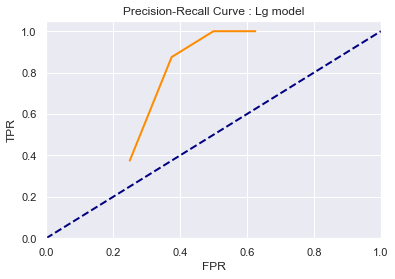

In [46]:
knn_probs = knn.predict_proba(x_test)[:,1] # Probability of obtaining 1  #מחזיר נאמפי אריי שהוא ההסתברות שזה חוזה, ואז ואפשר לקחת עמודה ספציפית
tpr_scores = []
fpr_scores = []
thresholds = np.arange(0, 1, 0.001)
for threshold in thresholds:
    t_tpr,t_fpr = get_threshold_tpr_fpr(threshold, knn_probs, y_test)
    #print(t_tpr,t_fpr)
    tpr_scores.append(t_tpr)
    fpr_scores.append(t_fpr)
#3.
plt.plot(fpr_scores,tpr_scores, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Precision-Recall Curve : Lg model')
plt.show()

In [47]:
auc = roc_auc_score(y_test, lg_probs)
print(f"AUC = {round(auc,2)}")

AUC = 0.98
